In [1]:
import torch
import copy
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets

import matplotlib.pyplot as plt
import numpy as np
import os
import mytools
import pandas as pd

import spconv.pytorch as spconv
from spconv.pytorch import functional as Fsp
from spconv.pytorch.utils import PointToVoxel
from spconv.pytorch.hash import HashTable
import contextlib

# Prepare Data

In [2]:
# Read pandas dataframe with all information about sparse training tensors
st_info = pd.read_pickle('/home/majd/sparse_training_tensors/sparse_tensor_info.pk')
st_info.head()

,dir,offset,diff
0,"[-0.4198009988390553, -0.4440823098716106, 0.7...","[-0.13160994280565688, 0.44427934344609393, -2...",0.020573
1,"[0.9292584753858835, 0.36787504773435054, -0.0...","[-2.8848038745477615, -0.18587373584726274, -2...",0.032068
2,"[0.6975108938815566, -0.6644836831430804, 0.26...","[-2.640509097021054, 0.40556093511292457, 0.66...",0.043303
3,"[0.32184656062767913, 0.5144094887414011, 0.79...","[1.5512170253679882, -1.523265044801098, -2.37...",0.025124
4,"[-0.5064111899864489, -0.6946257429389592, -0....","[0.16089299282025019, 2.8954267960229534, 0.37...",0.016838


In [3]:
# Make custom dataset
MyDataset = mytools.CustomDataset(dir_loc='/home/majd/sparse_training_tensors/', st_info=st_info)

# Split datat into training, validation, and testing sets
train_dataset, val_dataset = torch.utils.data.random_split(MyDataset,[0.8, 0.2], generator=torch.Generator().manual_seed(42))

print("Training samples: ", len(train_dataset))
print("Validation samples: ", len(val_dataset))

# Create DataLoaders
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Training samples:  1943113
Validation samples:  485778


# Visualize Data

In [4]:
# Print tensor shapes
for X_plot, y_plot, offset_plot in train_dataloader:
    print(f"Shape of X [N, C, H, W, D]: {X_plot.shape}")
    print(f"Shape of y: {y_plot.shape} {y_plot.dtype}")
    print("Offsets: ", offset_plot.shape)
    break


Shape of X [N, C, H, W, D]: torch.Size([64, 1, 120, 120, 120])
Shape of y: torch.Size([64, 3]) torch.float32
Offsets:  torch.Size([64, 3])


In [5]:
#Record shape of voxel grid
grid_shape = X_plot.shape[2:]
print("Voxel grid shape: " , grid_shape)

Voxel grid shape:  torch.Size([120, 120, 120])


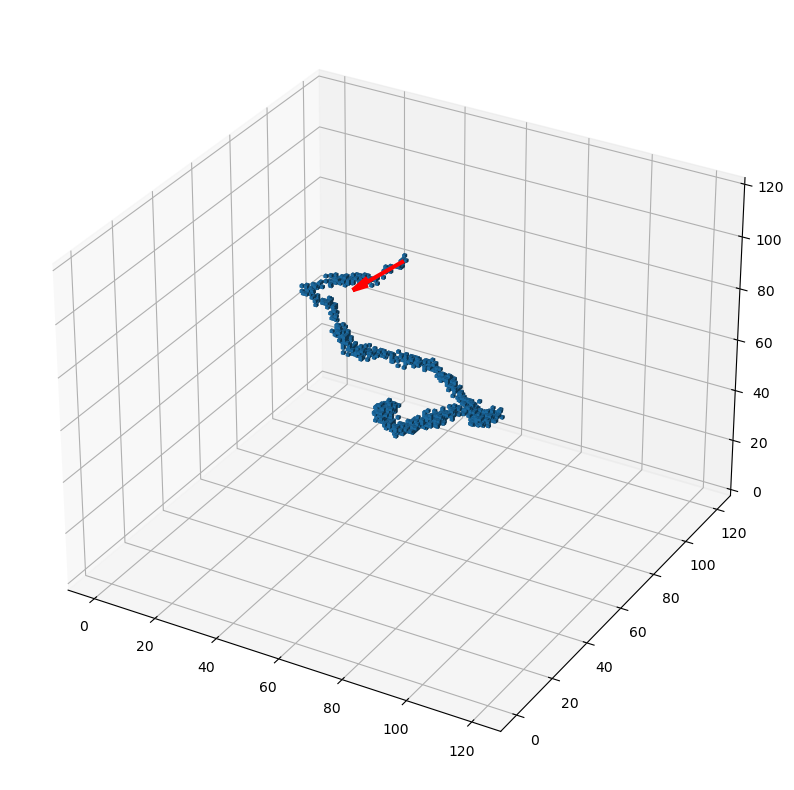

In [6]:
# Plot an example as a sanity check

# x/y/z length being kept in cm
eff_l = 3.0
# Voxel size in cm
vox_l = 0.05

index = 2
mytools.plot_tensor_dir(tensor = X_plot.to_dense().numpy()[index], start = offset_plot[index].numpy(), direction = y_plot[index].numpy(), eff_l=eff_l, vox_l=vox_l)

# Define Convnet Architecture

In [10]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self, shape):
        super(NeuralNetwork, self).__init__()
        self.net = spconv.SparseSequential(
            spconv.SparseConv3d(in_channels=1, out_channels=50, kernel_size=6, stride=2, bias=True),
            nn.ReLU(),
            spconv.SparseMaxPool3d(kernel_size=2, stride=2),
            spconv.SparseConv3d(in_channels=50, out_channels=30, kernel_size=4, stride=1, bias=True),
            nn.ReLU(),
            spconv.SparseConv3d(in_channels=30, out_channels=20, kernel_size=3, stride=1, bias=True),
            nn.ReLU(),
            spconv.SparseMaxPool3d(kernel_size=2, stride=2),
            spconv.ToDense(),
            
        )

        self.fc1 = nn.Linear(12**3 *20, 100)
        self.fc2_1 = nn.Linear(100, 30)
        self.fc3_1 = nn.Linear(30, 3)
        self.fc2_2 = nn.Linear(100, 30)
        self.fc3_2 = nn.Linear(30, 1)
        
        self.shape = shape
        

    def forward(self, x: torch.Tensor):
        
        x_sp = spconv.SparseConvTensor.from_dense(x.reshape(-1, self.shape[0], self.shape[1], self.shape[2], 1))
        
        
        x = self.net(x_sp)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x1 = torch.tanh(self.fc2_1(x))
        output1 = F.normalize(self.fc3_1(x1),dim=1)
        x2 = F.relu(self.fc2_2(x))
        output2 = F.softplus(self.fc3_2(x2))
                
        return output1,output2
    

model = NeuralNetwork(shape = grid_shape ).to(device)

# Print a nicer model summary
print(model)

Using cuda device
NeuralNetwork(
  (net): SparseSequential(
    (0): SparseConv3d(1, 50, kernel_size=[6, 6, 6], stride=[2, 2, 2], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], algo=ConvAlgo.Native)
    (1): ReLU()
    (2): SparseMaxPool3d(kernel_size=[2, 2, 2], stride=[2, 2, 2], padding=[0, 0, 0], dilation=[1, 1, 1], algo=ConvAlgo.MaskImplicitGemm)
    (3): SparseConv3d(50, 30, kernel_size=[4, 4, 4], stride=[1, 1, 1], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], algo=ConvAlgo.Native)
    (4): ReLU()
    (5): SparseConv3d(30, 20, kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], algo=ConvAlgo.MaskImplicitGemm)
    (6): ReLU()
    (7): SparseMaxPool3d(kernel_size=[2, 2, 2], stride=[2, 2, 2], padding=[0, 0, 0], dilation=[1, 1, 1], algo=ConvAlgo.MaskImplicitGemm)
    (8): ToDense()
  )
  (fc1): Linear(in_features=34560, out_features=100, bias=True)
  (fc2_1): Linear(in_features=100, out_features=

# Train the model

In [11]:
# Specify optimizer
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.0001, betas=(0.94, 0.999), eps=1e-07)

# Define Loss function
def loss_fn(output, target):
    
    # target us the x parameters in the Kent distribution
    G = output[0] # \gamma_1 parameters in Kent distribution
    K = output[1] # \kappa parameters in Kent distribution
    
    # Compute negative log likelihood using Kent distribution
    loss = torch.sum( -1.0*torch.log(torch.div(K,4*torch.pi*torch.sinh(K))).flatten() - ( K.flatten() * torch.sum(G*target,dim=1) ) )
    
    return loss

In [ ]:
# Implement early stopping in training loop
# Stop if validation loss has not decreased for the last [patience] epochs
# The model with the lowest loss is stored
patience = 2

Training_losses = np.array([])
Validation_losses = np.array([])

epochs = 1000
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    Training_losses = np.append(Training_losses, mytools.train(train_dataloader, model, loss_fn, optimizer, device))
    Validation_losses = np.append(Validation_losses, mytools.validate(val_dataloader, model, loss_fn, device))
    
    # Keep a running copy of the model with the lowest loss
    if Validation_losses[-1] == np.min(Validation_losses):
        final_model = copy.deepcopy(model)
    
    if len(Validation_losses) > patience:
        if np.sum((Validation_losses[-1*np.arange(patience)-1] - Validation_losses[-1*np.arange(patience)-2]) < 0) == 0:
            print("Stopping early!")
            break
            
print("Done!")

Epoch 1
-------------------------------
Current batch training loss: 162.767151  [    0/1943113]
Current batch training loss: 152.022415  [ 6400/1943113]
Current batch training loss: 146.628723  [12800/1943113]
Current batch training loss: 135.173828  [19200/1943113]
Current batch training loss: 147.948868  [25600/1943113]
Current batch training loss: 135.658035  [32000/1943113]
Current batch training loss: 142.757278  [38400/1943113]
Current batch training loss: 138.589310  [44800/1943113]
Current batch training loss: 136.649734  [51200/1943113]
Current batch training loss: 137.898270  [57600/1943113]
Current batch training loss: 128.846481  [64000/1943113]
Current batch training loss: 122.278091  [70400/1943113]
Current batch training loss: 119.948273  [76800/1943113]
Current batch training loss: 135.943420  [83200/1943113]
Current batch training loss: 110.445801  [89600/1943113]
Current batch training loss: 129.115997  [96000/1943113]
Current batch training loss: 118.844009  [102400

# Visualize Training

In [ ]:
# Plot Training and Validation Loss
# Indicate where the final model stopped training

best_epoch = np.argmin(Validation_losses)

plt.plot(np.arange(len(Training_losses)),Training_losses,label="Training Loss")
plt.plot(np.arange(len(Validation_losses)),Validation_losses,label="Validation Loss")
plt.axvline(best_epoch,label="Final model stopped here",color='k')
plt.xlabel('Epoch')
plt.ylabel('Cosine Similarity Loss')
plt.legend()


# Save the Model

In [ ]:
torch.save(final_model, "../3D_Heteroscedastic_Convnet_models/3D_HSCDC_CNN_spconv.pt")
print("Saved PyTorch Model State to ../3D_Heteroscedastic_Convnet_models/3D_HSCDC_CNN_spconv.pt")